In [1]:
!git clone https://github.com/nicknochnack/ImageClassification.git

Cloning into 'ImageClassification'...
remote: Enumerating objects: 312, done.
remote: Total 312 (delta 0), reused 0 (delta 0), pack-reused 312 (from 1)
Receiving objects: 100% (312/312), 106.29 MiB | 15.05 MiB/s, done.


In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import tensorflow
import os

In [4]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tensorflow.config.experimental.set_memory_growth(gpu, True)

In [5]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
import cv2
import imghdr

<ipython-input-6-290956b76b78>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'ImageClassification/data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
from tensorflow import keras
data = tensorflow.keras.utils.image_dataset_from_directory('ImageClassification/data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

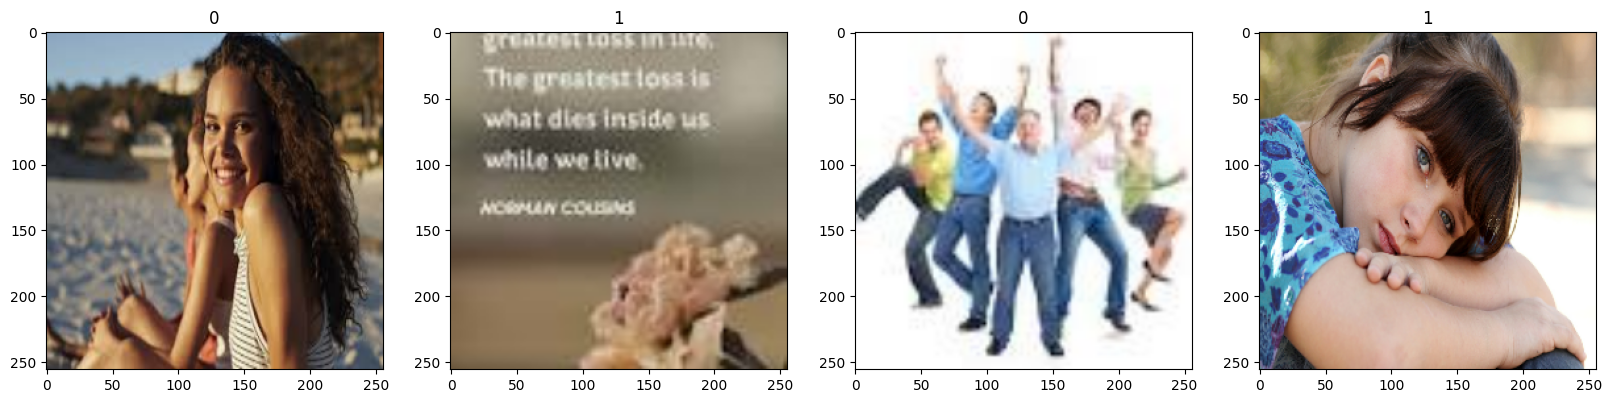

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[6.70588255e-01, 3.84313732e-01, 5.52941203e-01],
          [6.70588255e-01, 3.84313732e-01, 5.52941203e-01],
          [6.73039198e-01, 3.86764705e-01, 5.55392146e-01],
          ...,
          [8.41666639e-01, 5.67156851e-01, 5.20098031e-01],
          [8.39215696e-01, 5.64705908e-01, 5.17647088e-01],
          [8.35784316e-01, 5.61274529e-01, 5.14215708e-01]],
 
         [[6.70588255e-01, 3.84313732e-01, 5.52941203e-01],
          [6.70588255e-01, 3.84313732e-01, 5.52941203e-01],
          [6.73039198e-01, 3.86764705e-01, 5.55392146e-01],
          ...,
          [8.42766762e-01, 5.68256915e-01, 5.21198094e-01],
          [8.40315759e-01, 5.65805972e-01, 5.18747151e-01],
          [8.38351130e-01, 5.63841343e-01, 5.16782522e-01]],
 
         [[6.70588255e-01, 3.86588544e-01, 5.48391521e-01],
          [6.70588255e-01, 3.86588544e-01, 5.48391521e-01],
          [6.73039198e-01, 3.89039516e-01, 5.50842524e-01],
          ...,
          [8.44559014e-01, 5.70049226e-01, 5.2299

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [19]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze base layers

for layer in base_model.layers[-5:]:  # ✅ Corrected
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Convert feature maps to a vector
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Change to softmax for multi-class classification
])
for layer in base_model.layers:
    print(layer.name, "Trainable:", layer.trainable)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_layer Trainable: False
rescaling Trainable: False
normalization Trainable: False
stem_conv Trainable: False
stem_bn Trainable: False
stem_activation Trainable: False
block1a_project_conv Trainable: False
block1a_project_bn Trainable: False
block1a_project_activation Trainable: False
block2a_expand_conv Trainable: False
block2a_expand_bn Trainable: False
block2a_expand_activation Trainable: False
block2a_project_conv Trainable: False
block2a_project_bn Trainable: False
block2b_expand_conv Trainable: False
block2b_expand_bn Trainable: False
block2b_expand_activation Trainable: False
block2b_project_conv Trainable: False
block2b_project_bn Trainable: False
block2b_drop Trainable: False
block2b_add Trainable: False
block3a_expand_conv Trainable: False
block3a_expand_bn Trainable: False
block3a_expand_activation Trainable: False
block3a_project_conv Trainable: False
block3a_project_bn Trainable: False
block3b_expand_conv Trainable: Fa

In [20]:
model.compile('adam', loss=tensorflow.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 8, 8, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,247,505 (23.83 MB)

 Trainable params: 576,513 (2.20 MB)

 Non-trainable params: 5,670,992 (21.63 MB)

In [22]:
logdir='logs'

In [23]:
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4734 - loss: 0.8181 - val_accuracy: 0.5469 - val_loss: 0.6871
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.5317 - loss: 0.7044 - val_accuracy: 0.5312 - val_loss: 0.6879
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6525 - loss: 0.6868 - val_accuracy: 0.5312 - val_loss: 0.6824
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - accuracy: 0.5735 - loss: 0.7286 - val_accuracy: 0.7188 - val_loss: 0.6615
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.5868 - loss: 0.6820 - val_accuracy: 0.4844 - val_loss: 0.6884
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 663ms/step - accuracy: 0.5334 - loss: 0.7111 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.5888 - loss: 0.6829 - val_accuracy: 0.5312 - val_loss: 0.7141
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.6569 - loss: 0.6431 - val_accuracy: 0.5781 - val_loss: 0.64

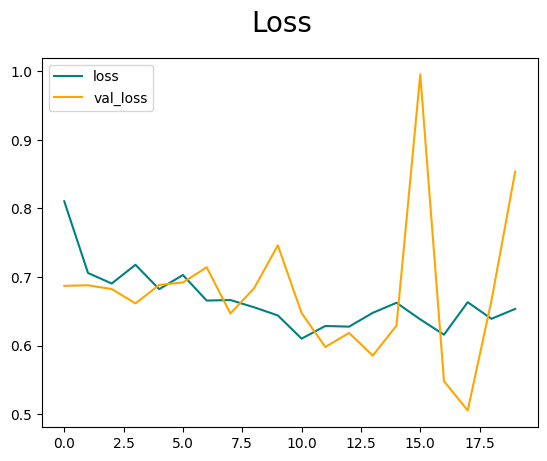

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

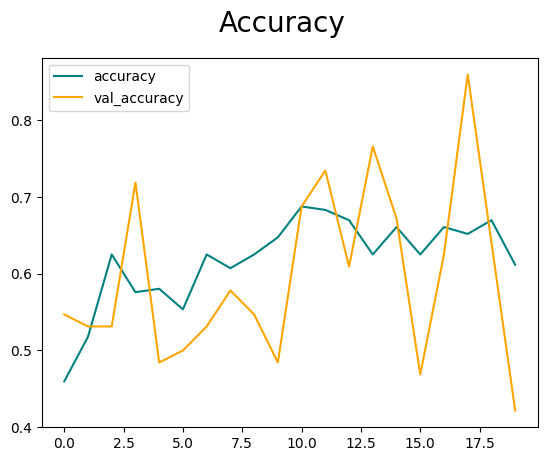

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [27]:
import cv2

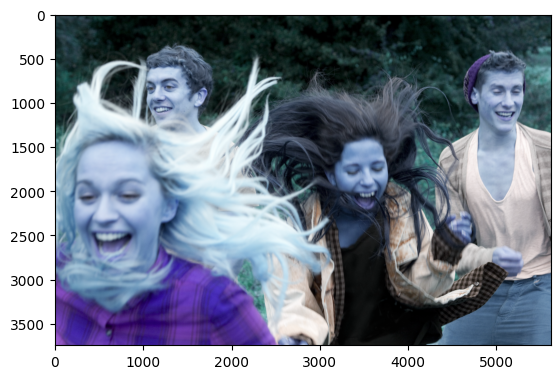

In [40]:
img = cv2.imread('ImageClassification/154006829.jpg')
plt.imshow(img)
plt.show()

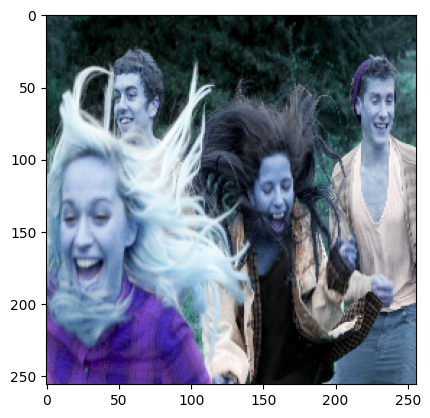

In [41]:
resize = tensorflow.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [43]:
yhat

array([[0.20428427]], dtype=float32)

In [44]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [45]:
from tensorflow.keras.models import save_model

In [46]:
keras.models.save_model(model, 'my_model.keras')